# Business Problem

The company is concerned about its employee turnover and wants to use their HR data to: 

- predict employee engagement and satisfaction
- predict who is likely to terminate their employment

They also want recommendations on what interventions may help to reduce employee turnover.

# Business Value

It is more cost-effective for the company to address the underlying issues behind employee termination than to hire and train new employees. By predicting who is likely to terminate employment (without relying on employee disclosure on survey data), the company can intervene before employment is terminated. 

# Methodology

- Prepare the data for modeling
- Use regression to predict a continuous target that measures employee satisfaction and engagement
- Use classification to predict which employees are likely to terminate their employment
- Use statistical analysis and data visualizations to summarize the findings and make recommendations
- Create a Tableau storyboard to present the findings


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
df = pd.read_csv('HRDataset_v14.csv')
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee_Name               311 non-null    object 
 1   EmpID                       311 non-null    int64  
 2   MarriedID                   311 non-null    int64  
 3   MaritalStatusID             311 non-null    int64  
 4   GenderID                    311 non-null    int64  
 5   EmpStatusID                 311 non-null    int64  
 6   DeptID                      311 non-null    int64  
 7   PerfScoreID                 311 non-null    int64  
 8   FromDiversityJobFairID      311 non-null    int64  
 9   Salary                      311 non-null    int64  
 10  Termd                       311 non-null    int64  
 11  PositionID                  311 non-null    int64  
 12  Position                    311 non-null    object 
 13  State                       311 non

# Explore the Data and Engineer Features

In [4]:
# There are no repeated and no null values for employee name
df['Employee_Name'].nunique(), (df['Employee_Name'].isna()).sum()

(311, 0)

In [5]:
# There are no repeated and no null values for employee name
df['EmpID'].nunique(), (df['EmpID'].isna()).sum()

(311, 0)

In [6]:
#60% of the employees are not married
df['MarriedID'].value_counts(normalize=True)

0    0.601286
1    0.398714
Name: MarriedID, dtype: float64

In [7]:
#Numerical coding of MaritalDesc column
df['MaritalStatusID'].value_counts(normalize=True)

0    0.440514
1    0.398714
2    0.096463
3    0.038585
4    0.025723
Name: MaritalStatusID, dtype: float64

In [8]:
df['MaritalDesc'].value_counts(normalize=True)

Single       0.440514
Married      0.398714
Divorced     0.096463
Separated    0.038585
Widowed      0.025723
Name: MaritalDesc, dtype: float64

Because there is not an ordinal relationship between the marital categories, it does not make sense to have them numerically coded. Since these will need to be on-hot-encoded for any models, I am going to drop the numerical column and keep the one with the descriptions, as it is easier to use.

In [9]:
df.drop('MaritalStatusID', axis=1, inplace=True)

In [10]:
#Numerical coding for Sex column; slight more than half of the employees are
#female
df['GenderID'].value_counts(normalize=True)

0    0.565916
1    0.434084
Name: GenderID, dtype: float64

In [11]:
df['Sex'].value_counts(normalize=True)

F     0.565916
M     0.434084
Name: Sex, dtype: float64

In [12]:
df['EmpStatusID'].value_counts(normalize=True)

1    0.591640
5    0.282958
4    0.045016
3    0.045016
2    0.035370
Name: EmpStatusID, dtype: float64

In [13]:
df['EmploymentStatus'].value_counts(normalize=True)

Active                    0.665595
Voluntarily Terminated    0.282958
Terminated for Cause      0.051447
Name: EmploymentStatus, dtype: float64

The documentation states that these two columns should align. While 5 is clearly "Voluntarily Terminated," the other values are unclear. I am going to remove the numerically encoded column since it is ambiguous and most likely is incorrectly showing a numerical relationship. 

In [14]:
df.drop('EmpStatusID', axis=1, inplace=True)

In [15]:
df['DeptID'].value_counts(normalize=True)

5    0.668810
3    0.160772
6    0.102894
4    0.032154
1    0.032154
2    0.003215
Name: DeptID, dtype: float64

In [16]:
df["Department"].value_counts(normalize=True)

Production              0.672026
IT/IS                   0.160772
Sales                   0.099678
Software Engineering    0.035370
Admin Offices           0.028939
Executive Office        0.003215
Name: Department, dtype: float64

Department ID has the same issue as marital status. I will take the same approach with this column and with any others that are incorrectly coded to imply cardinality.

In [17]:
df.drop('DeptID', axis=1, inplace=True)

In [18]:
df['PerfScoreID'].value_counts(normalize=True)

3    0.781350
4    0.118971
2    0.057878
1    0.041801
Name: PerfScoreID, dtype: float64

In [19]:
df["PerformanceScore"].value_counts(normalize=True)

Fully Meets          0.781350
Exceeds              0.118971
Needs Improvement    0.057878
PIP                  0.041801
Name: PerformanceScore, dtype: float64

In [20]:
df.drop('PerfScoreID', axis=1, inplace=True)

In [21]:
#Just under 10% of the employees came from a diversity job fair
df['FromDiversityJobFairID'].value_counts(normalize=True)

0    0.906752
1    0.093248
Name: FromDiversityJobFairID, dtype: float64

In [22]:
#Salaries range from roughly $45,000 to $250,000. That is a reasonable range.
df['Salary'].describe()

count       311.000000
mean      69020.684887
std       25156.636930
min       45046.000000
25%       55501.500000
50%       62810.000000
75%       72036.000000
max      250000.000000
Name: Salary, dtype: float64

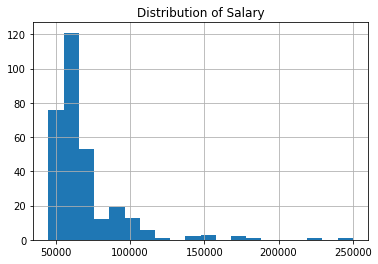

In [23]:
df['Salary'].hist(bins=20)
plt.title('Distribution of Salary');

The data are bimodal, with the largest number of employees making around \\$60,000 and another group (management?) clustered around \\$90,000.

In [24]:
df['Termd'].value_counts()

0    207
1    104
Name: Termd, dtype: int64

In [25]:
df['PositionID'].value_counts(normalize=True)

19    0.440514
20    0.183280
3     0.086817
18    0.041801
24    0.028939
14    0.025723
9     0.025723
15    0.016077
28    0.016077
8     0.016077
4     0.012862
13    0.012862
2     0.009646
1     0.009646
21    0.009646
22    0.009646
23    0.006431
26    0.006431
27    0.006431
16    0.003215
29    0.003215
17    0.003215
12    0.003215
11    0.003215
10    0.003215
7     0.003215
6     0.003215
5     0.003215
25    0.003215
30    0.003215
Name: PositionID, dtype: float64

In [26]:
df['Position'].value_counts()

Production Technician I         137
Production Technician II         57
Area Sales Manager               27
Production Manager               14
Software Engineer                10
IT Support                        8
Data Analyst                      7
Sr. Network Engineer              5
Database Administrator            5
Network Engineer                  5
BI Developer                      4
Sales Manager                     3
Senior BI Developer               3
Administrative Assistant          3
Accountant I                      3
IT Manager - DB                   2
Sr. Accountant                    2
Sr. DBA                           2
Shared Services Manager           1
Principal Data Architect          1
Data Architect                    1
IT Director                       1
Data Analyst                      1
IT Manager - Support              1
Director of Sales                 1
IT Manager - Infra                1
President & CEO                   1
CIO                         

In [27]:
df.drop('PositionID', axis=1, inplace=True)

I may want to bin these by broad category later.

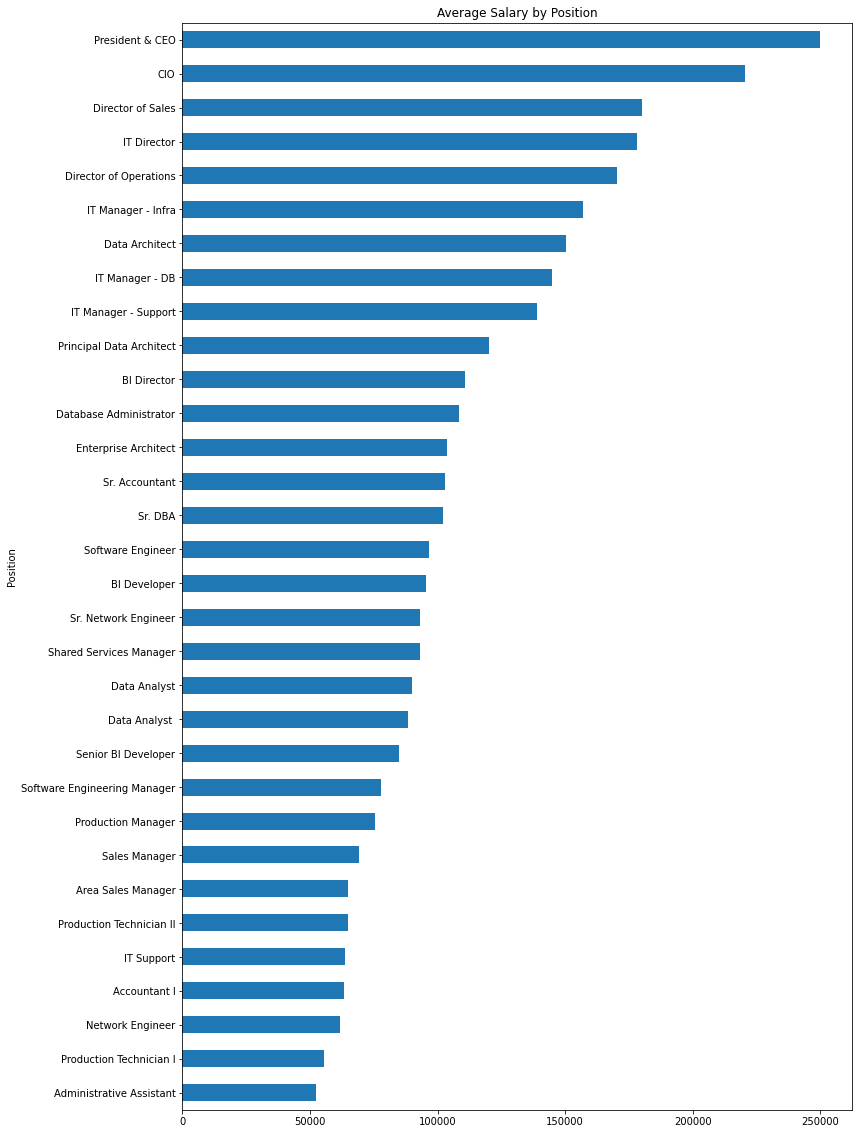

In [28]:
(df.groupby
     ('Position')
     ['Salary']
    .mean()
    .sort_values()
    .plot(
        kind='barh', 
        figsize=(12,20)
    )
)
plt.title('Average Salary by Position');

In [29]:
df['State'].value_counts(normalize=True)

MA    0.887460
CT    0.019293
TX    0.009646
VT    0.006431
CO    0.003215
ME    0.003215
VA    0.003215
MT    0.003215
NC    0.003215
NH    0.003215
TN    0.003215
NY    0.003215
GA    0.003215
UT    0.003215
ND    0.003215
IN    0.003215
AL    0.003215
RI    0.003215
PA    0.003215
OR    0.003215
FL    0.003215
AZ    0.003215
KY    0.003215
ID    0.003215
OH    0.003215
WA    0.003215
NV    0.003215
CA    0.003215
Name: State, dtype: float64

The vast majority of the employees are from MA and perhaps the rest are remote. First, I will check to make sure that the non-MA addresses are not only associated with people no longer employed by the company who may have moved and had their address updated.

In [30]:
df.groupby('State')['Termd'].sum()

State
AL     0
AZ     0
CA     0
CO     0
CT     1
FL     0
GA     0
ID     0
IN     0
KY     0
MA    99
ME     0
MT     0
NC     0
ND     0
NH     0
NV     0
NY     0
OH     1
OR     0
PA     1
RI     0
TN     1
TX     0
UT     0
VA     1
VT     0
WA     0
Name: Termd, dtype: int64

It does not appear that there is a correlation between employees having an out of state address and no longer working for the company. Since the majority of employees are in MA (and there does not seem to be a reason to keep the granularity of the individual states), I am going to create a binary column to indicate if the employee is in MA.

In [31]:
df['in_MA'] = np.where(df['State'] == 'MA', 1, 0)

In [32]:
df['Zip'].value_counts(normalize=True)

1886     0.041801
2176     0.022508
1810     0.022508
2451     0.022508
2045     0.022508
           ...   
1864     0.003215
1876     0.003215
1880     0.003215
21851    0.003215
1773     0.003215
Name: Zip, Length: 158, dtype: float64

The values seem to mainly be 4-digit numbers. 

In [33]:
#Check how many values are 5-digits
len([n for n in df['Zip'] if len(str(n)) == 5])

24

Upon research, zip codes in MA have a leading 0, which has been truncated in the current integer format. I will leave this column as-is for now, since it will not be used for modeling and can be transformed later for visualization if needed. 

In [34]:
#convert DOB to datetime
df['DOB'] = pd.to_datetime(df['DOB'])

In [35]:
#The oldest person was born in 1971 and there is at least one person coded as 
#being born in the future
df['DOB'].min(), df['DOB'].max()

(Timestamp('1971-07-10 00:00:00'), Timestamp('2070-12-22 00:00:00'))

In [36]:
#Since this data was updated in 2021, the maximum reasonable birth year is
# 2007, so I will look at the records after that date
df[df['DOB'] > '2007-01-01']

,Employee_Name,EmpID,MarriedID,GenderID,FromDiversityJobFairID,Salary,Termd,Position,State,Zip,...,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,in_MA
8,"Bachiochi, Linda",10114,0,0,1,47837,0,Production Technician I,MA,1902,...,12.0,Diversity Job Fair,Fully Meets,4.46,3,0,1/25/2019,0,4,1
16,"Beak, Kimberly",10023,1,0,0,70131,0,Production Technician II,MA,2145,...,18.0,Employee Referral,Exceeds,4.40,3,0,1/14/2019,0,16,1
17,"Beatrice, Courtney",10055,0,0,0,59026,0,Production Technician I,MA,1915,...,16.0,Google Search,Fully Meets,5.00,5,0,1/14/2019,0,12,1
20,"Bernstein, Sean",10046,0,1,0,51044,0,Production Technician I,MA,2072,...,11.0,Google Search,Fully Meets,5.00,3,0,1/14/2019,0,13,1
21,"Biden, Lowan M",10226,0,0,0,64919,0,Production Technician I,MA,2027,...,19.0,Indeed,Fully Meets,4.20,3,0,1/10/2019,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,"Vega, Vincent",10144,0,1,0,88976,0,Production Manager,MA,2169,...,2.0,Employee Referral,Fully Meets,3.93,3,0,2/27/2019,0,19,1
296,"Wallace, Courtney E",10274,1,0,1,80512,1,Production Manager,MA,2478,...,2.0,Diversity Job Fair,Fully Meets,4.50,3,0,1/2/2012,0,5,1
301,"Wilber, Barry",10048,1,1,0,55140,1,Production Technician I,MA,2324,...,11.0,Website,Fully Meets,5.00,3,0,2/15/2015,0,7,1
303,"Williams, Jacquelyn",10264,0,0,1,59728,1,Production Technician I,MA,2109,...,19.0,Diversity Job Fair,Fully Meets,4.30,4,0,6/2/2014,0,16,1


There is nothing else in the data to suggest that these are demo accounts or otherwise accounts to ignore. This suggests that these may be a result of a data entry error when the data were updated. 

In [37]:
df[df['DOB'] > '2007-01-01']['DOB'].sort_values()

41    2051-01-02
68    2051-02-25
61    2052-01-18
206   2052-02-11
124   2052-08-18
         ...    
76    2070-07-09
226   2070-09-22
152   2070-10-08
17    2070-10-27
20    2070-12-22
Name: DOB, Length: 61, dtype: datetime64[ns]

In [38]:
df[df['DOB'] < '2007-01-01']['DOB'].sort_values()

104   1971-07-10
108   1971-10-23
42    1972-02-09
157   1972-07-01
234   1972-07-03
         ...    
288   1991-05-23
80    1991-09-05
135   1992-05-07
110   1992-06-18
189   1992-08-17
Name: DOB, Length: 250, dtype: datetime64[ns]

It indeed appears that '19' was keyed in as '20' for employees born prior to 1971. As an extra check, I will examine the hire dates for the employees with the impossible birth dates. 

In [39]:
df[df['DOB'] > '2007-01-01']['DateofHire'].sort_values()

24     1/10/2011
76      1/5/2014
254     1/5/2015
225     1/6/2014
142     1/6/2014
         ...    
278    9/29/2014
41     9/29/2014
27     9/30/2013
140    9/30/2013
98      9/6/2011
Name: DateofHire, Length: 61, dtype: object

Based on the evidence I have, I will amend the birthdates to reflect that they were born prior to 1971.

In [40]:
def fix_dob(date):
    "Subtract 100 from the years after 2000 to correct the errors."
    new_year = date.year
    if new_year > 2000:
        new_year = new_year - 100
    return date.replace(year=new_year)
        

df['DOB'] = df['DOB'].apply(fix_dob)

In [41]:
#Add a current age column
df['current_age'] = df['DOB'].apply(
    lambda x: relativedelta(datetime.today(), 
                            x
                           ).years
)

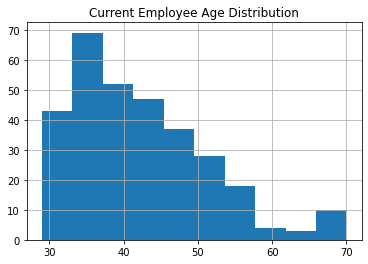

In [42]:
df['current_age'].hist()
plt.title('Current Employee Age Distribution');

In [43]:
df['current_age'].describe()

count    311.000000
mean      42.389068
std        8.863467
min       29.000000
25%       35.000000
50%       41.000000
75%       48.000000
max       70.000000
Name: current_age, dtype: float64

The age distribution is bimodal, with the vast majority of employees having a current age between 35 and 45 and a smaller peak between 65 and 70.

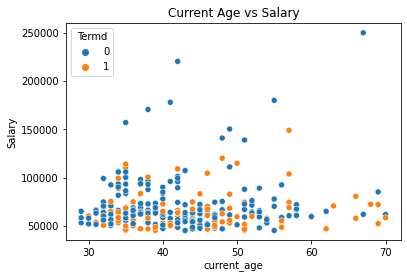

In [44]:
sns.scatterplot(data=df, x='current_age', y='Salary', hue='Termd')
plt.title('Current Age vs Salary');

At first glance, there is no clear correlation between current age, salary and employment status.

In [45]:
df['CitizenDesc'].value_counts()

US Citizen             295
Eligible NonCitizen     12
Non-Citizen              4
Name: CitizenDesc, dtype: int64

Because there are so few non-citizens, I am going to change this to a binary column with 1 (citizen) and 0 (non-citizen).

In [46]:
df['citizen'] = np.where(df['CitizenDesc'] == 'US Citizen', 1, 0)
df.drop('CitizenDesc', axis=1, inplace=True)

In [47]:
#Coded with two different capitalizations
df['HispanicLatino'].value_counts()

No     282
Yes     27
no       1
yes      1
Name: HispanicLatino, dtype: int64

In [48]:
#Replace with binary
df['HispanicLatino'] = np.where(df['HispanicLatino'].str.lower() == 'yes', 1, 0)

In [49]:
df['RaceDesc'].value_counts(normalize=True)

White                               0.601286
Black or African American           0.257235
Asian                               0.093248
Two or more races                   0.035370
American Indian or Alaska Native    0.009646
Hispanic                            0.003215
Name: RaceDesc, dtype: float64

In [50]:
#All of the hires from the diversity job fair identify as Black or
#African American
pd.crosstab(df['RaceDesc'], df['FromDiversityJobFairID'])

FromDiversityJobFairID,0,1
RaceDesc,,
American Indian or Alaska Native,3,0
Asian,29,0
Black or African American,51,29
Hispanic,1,0
Two or more races,11,0
White,187,0


In [51]:
df['DateofHire'] = pd.to_datetime(df['DateofHire'])

In [52]:
df['age_hired'] = df['DateofHire'] - df['DOB']
df['age_hired'] =df['age_hired']//np.timedelta64(1,'Y')

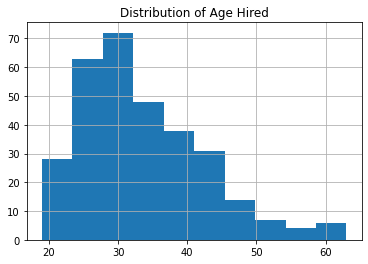

In [53]:
#The shape of this distribution is similar to current age
df['age_hired'].hist()
plt.title('Distribution of Age Hired');

In [54]:
df['DateofTermination'] = pd.to_datetime(
    df['DateofTermination'], 
    errors='coerce'
)

In [55]:
df['employment_months'] = df['DateofTermination'] - df['DateofHire']
df['employment_months'] = df['employment_months']//np.timedelta64(1,'M')

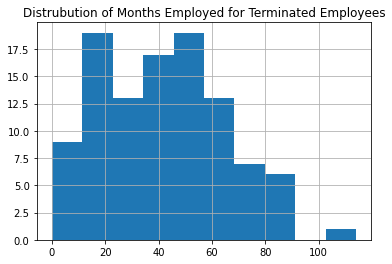

In [56]:
df['employment_months'].hist()
plt.title('Distrubution of Months Employed for Terminated Employees');

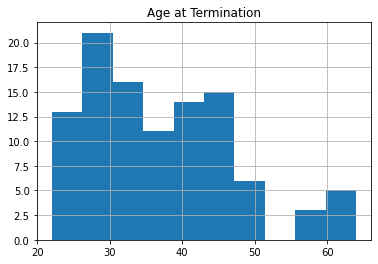

In [90]:
df['age_at_termination'] = df['DateofTermination'] - df['DOB']
df['age_at_termination'] = df['age_at_termination']//np.timedelta64(1,'Y')
df['age_at_termination'].hist()
plt.title('Age at Termination');

In [57]:
df['TermReason'].value_counts()

N/A-StillEmployed                   207
Another position                     20
unhappy                              14
more money                           11
career change                         9
hours                                 8
attendance                            7
relocation out of area                5
return to school                      5
military                              4
no-call, no-show                      4
retiring                              4
performance                           4
maternity leave - did not return      3
medical issues                        3
gross misconduct                      1
Fatal attraction                      1
Learned that he is a gangster         1
Name: TermReason, dtype: int64

In [100]:
df['EmploymentStatus'].value_counts(normalize=True)

Active                    0.665595
Voluntarily Terminated    0.282958
Terminated for Cause      0.051447
Name: EmploymentStatus, dtype: float64

In [58]:
df['Department'].value_counts()

Production              209
IT/IS                    50
Sales                    31
Software Engineering     11
Admin Offices             9
Executive Office          1
Name: Department, dtype: int64

In [59]:
by_department = df.groupby('Department').agg(
    {
        'EmpID': 'count', 
        'current_age':'mean',
        'Salary':'mean',
        'Termd': 'sum'
    }
)
by_department.columns = ['count', 'mean_age', 'mean_salary', 'num_terminated']
by_department['percent_terminated'] = round(by_department['num_terminated']/by_department['count']*100,2)

In [60]:
by_department

,count,mean_age,mean_salary,num_terminated,percent_terminated
Department,,,,,
Admin Offices,9,35.777778,71791.888889,2,22.22
Executive Office,1,67.000000,250000.000000,0,0.00
IT/IS,50,41.580000,97064.640000,10,20.00
Production,209,42.889952,59953.545455,83,39.71
Sales,31,42.580645,69061.258065,5,16.13
Software Engineering,11,39.181818,94989.454545,4,36.36


The departments with the highest turnover rates are production and software engineering. This will need to be investigated further. 

In [61]:
#Examine the number of managers and the number of reports they have
df['ManagerName'].value_counts()

Michael Albert        22
Brannon Miller        22
Kelley Spirea         22
Elijiah Gray          22
Kissy Sullivan        22
Amy Dunn              21
Ketsia Liebig         21
David Stanley         21
Webster Butler        21
Janet King            19
Simon Roup            17
Peter Monroe          14
John Smith            14
Lynn Daneault         13
Alex Sweetwater        9
Brian Champaigne       8
Jennifer Zamora        7
Brandon R. LeBlanc     7
Eric Dougall           4
Debra Houlihan         3
Board of Directors     2
Name: ManagerName, dtype: int64

In [62]:
#There are no records missing a manager name, but 8 missing a manager ID
df['ManagerID'].isna().sum()

8

In [63]:
df[df['ManagerID'].isna()]['ManagerName']

19     Webster Butler
30     Webster Butler
44     Webster Butler
88     Webster Butler
135    Webster Butler
177    Webster Butler
232    Webster Butler
251    Webster Butler
Name: ManagerName, dtype: object

In [64]:
#The missing manager ID should be 39, to correspond to Webster Butler
df[df['ManagerName'] == 'Webster Butler']['ManagerID'].value_counts()

39.0    13
Name: ManagerID, dtype: int64

In [65]:
#Impute the missing values
df['ManagerID'].fillna(39, inplace=True)

In [111]:
emp_by_manager = pd.crosstab(df['ManagerName'], df['EmploymentStatus'])

emp_by_manager['total'] = (
    emp_by_manager['Active'] + 
    emp_by_manager['Terminated for Cause'] + 
    emp_by_manager['Voluntarily Terminated']
)

emp_by_manager['cause_percent'] = round(
    emp_by_manager['Terminated for Cause']/
    emp_by_manager['total'],
    4
) *100

emp_by_manager['volun_percent'] = round(
    emp_by_manager['Voluntarily Terminated']/
    emp_by_manager['total'],
    4
) *100

emp_by_manager['total_term_percent'] = (
    emp_by_manager['cause_percent'] +
emp_by_manager['volun_percent'])

emp_by_manager['cause_dif_from_mean'] = (
    emp_by_manager['cause_percent'] - 
    emp_by_manager['cause_percent'].mean()
)

emp_by_manager['volun_dif_from_mean'] = (
    emp_by_manager['volun_percent'] - 
    emp_by_manager['volun_percent'].mean()
)

emp_by_manager['total_term_dif_from_mean'] = (
    emp_by_manager['total_term_percent'] - 
    emp_by_manager['total_term_percent'].mean()
)


emp_by_manager

EmploymentStatus,Active,Terminated for Cause,Voluntarily Terminated,total,cause_percent,volun_percent,total_term_percent,cause_dif_from_mean,volun_dif_from_mean,total_term_dif_from_mean
ManagerName,,,,,,,,,,
Alex Sweetwater,6,1,2,9,11.11,22.22,33.33,6.297619,-0.918571,5.379048
Amy Dunn,8,0,13,21,0.00,61.90,61.90,-4.812381,38.761429,33.949048
Board of Directors,2,0,0,2,0.00,0.00,0.00,-4.812381,-23.138571,-27.950952
Brandon R. LeBlanc,5,1,1,7,14.29,14.29,28.58,9.477619,-8.848571,0.629048
Brannon Miller,16,0,6,22,0.00,27.27,27.27,-4.812381,4.131429,-0.680952
Brian Champaigne,8,0,0,8,0.00,0.00,0.00,-4.812381,-23.138571,-27.950952
David Stanley,15,0,6,21,0.00,28.57,28.57,-4.812381,5.431429,0.619048
Debra Houlihan,2,0,1,3,0.00,33.33,33.33,-4.812381,10.191429,5.379048
Elijiah Gray,14,1,7,22,4.55,31.82,36.37,-0.262381,8.681429,8.419048


There are definitely some patterns between employment status and manager that will need to be investigated further.

In [66]:
df['RecruitmentSource'].value_counts(normalize=True)

Indeed                     0.279743
LinkedIn                   0.244373
Google Search              0.157556
Employee Referral          0.099678
Diversity Job Fair         0.093248
CareerBuilder              0.073955
Website                    0.041801
Other                      0.006431
On-line Web application    0.003215
Name: RecruitmentSource, dtype: float64

The diversity job fair is already accounted for in another column, so is not needed here. Many of the other categories are too granular, since this data is not going to be used to change how job openings are posted or marketed. I'm going to bin these into job_board, referral and other.

In [67]:
def bin_source(source):
    """Bins the recruitment source into three categories."""
    
    if source in ['Indeed', 'LinkedIn', 'CareerBuilder']:
        return 'job_board'
    elif source == 'Employee Referral':
        return 'referral'
    return 'other'

df['RecruitmentSource'] = df['RecruitmentSource'].apply(bin_source)

In [68]:
df['RecruitmentSource'].value_counts()

job_board    186
other         94
referral      31
Name: RecruitmentSource, dtype: int64

In [69]:
df['PerformanceScore'].value_counts(normalize=True)

Fully Meets          0.781350
Exceeds              0.118971
Needs Improvement    0.057878
PIP                  0.041801
Name: PerformanceScore, dtype: float64

In [70]:
employment_by_performance = pd.crosstab(df['PerformanceScore'], df['Termd'])
employment_by_performance.columns = ['employed', 'terminated']
employment_by_performance['percent_term'] = (
    employment_by_performance['terminated']/
    (
        employment_by_performance['terminated'] +
        employment_by_performance['employed']
    )
)
employment_by_performance

,employed,terminated,percent_term
PerformanceScore,,,
Exceeds,29,8,0.216216
Fully Meets,162,81,0.333333
Needs Improvement,8,10,0.555556
PIP,8,5,0.384615


In [71]:
pd.crosstab(df['TermReason'], df['PerformanceScore'])

PerformanceScore,Exceeds,Fully Meets,Needs Improvement,PIP
TermReason,,,,
Another position,2,17,0,1
Fatal attraction,0,0,0,1
Learned that he is a gangster,0,1,0,0
N/A-StillEmployed,29,162,8,8
attendance,0,4,3,0
career change,0,6,2,1
gross misconduct,1,0,0,0
hours,0,8,0,0
maternity leave - did not return,1,2,0,0


Considering that employees classified as Needs Improvement leave more often and by their own decision than those on a PIP, perhaps there may be a need to offer more support at an earlier stage to struggling employees. However, it is important to note that the majority of employees whoa re no longer employed with the company met or exceeded expectations.

In [72]:
df['EngagementSurvey'].describe()

count    311.000000
mean       4.110000
std        0.789938
min        1.120000
25%        3.690000
50%        4.280000
75%        4.700000
max        5.000000
Name: EngagementSurvey, dtype: float64

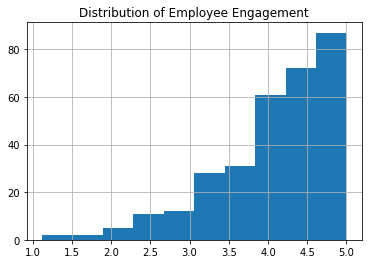

In [73]:
#The engagement data are skewed left, showing that the majority of employees 
#are engaged
df['EngagementSurvey'].hist()
plt.title('Distribution of Employee Engagement');

In [74]:
df['EmpSatisfaction'].value_counts(normalize=True)

3    0.347267
5    0.315113
4    0.302251
2    0.028939
1    0.006431
Name: EmpSatisfaction, dtype: float64

I want to use the other features (excluding those that contain information about termination) to be able to predict employees' responses on the survey. It may be best to engineer a single target metric out of satisfaction and engagement. I'll start with just a sum of the two and adjust later, if needed. 

In [75]:
df['combined_target'] = df['EngagementSurvey'] + df['EmpSatisfaction']

In [76]:
df['SpecialProjectsCount'].value_counts()

0    241
6     21
5     21
7     12
4      9
3      3
8      2
2      1
1      1
Name: SpecialProjectsCount, dtype: int64

With the data clustered at 0 and the higher numbers, I am going to bin these into three categories.

In [77]:
def bin_projects(count):
    """Bins the project counts into three categories."""
    
    if count == 0:
        return 'none'
    elif count < 5:
        return 'few'
    return 'many'

df['SpecialProjectsCount'] = df['SpecialProjectsCount'].apply(bin_projects)

df['SpecialProjectsCount'].value_counts()

none    241
many     56
few      14
Name: SpecialProjectsCount, dtype: int64

In [78]:
df['LastPerformanceReview_Date'] = pd.to_datetime(df['LastPerformanceReview_Date'])

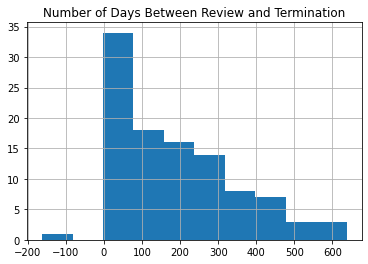

In [79]:
df['review_to_term'] = df['DateofTermination'] - df['LastPerformanceReview_Date'] 
df['review_to_term'] = df['review_to_term']//np.timedelta64(1,'D')
df['review_to_term'].hist()
plt.title('Number of Days Between Review and Termination');

In [80]:
df[df['review_to_term'] < 0]

,Employee_Name,EmpID,MarriedID,GenderID,FromDiversityJobFairID,Salary,Termd,Position,State,Zip,...,LastPerformanceReview_Date,DaysLateLast30,Absences,in_MA,current_age,citizen,age_hired,employment_months,combined_target,review_to_term
95,"Forrest, Alex",10305,1,1,0,70187,1,Area Sales Manager,MA,2330,...,2019-01-28,4,7,1,46,1,39,46.0,7.0,-162.0


One employee has a termination date before their last review. Because I am not going to use this column in a predictive model and the rest of the data in this record looks fine, I am going to keep it for now.

In [81]:
df['DaysLateLast30'].value_counts()

0    278
4      8
6      6
5      6
3      6
2      6
1      1
Name: DaysLateLast30, dtype: int64

Because it looks like there are not excessive tardies overall, I am going to make this a binary column with yes (1) and no (0).

In [82]:
df['DaysLateLast30'] = np.where(df['DaysLateLast30'] == 0, 0, 1)

In [83]:
df['Absences'].describe()

count    311.000000
mean      10.237942
std        5.852596
min        1.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       20.000000
Name: Absences, dtype: float64

In [93]:
df['Absences'].unique()

array(['5_or_fewer', '16_or_more', '11-15', '6-10'], dtype=object)

In [85]:
#Bin the number of absences

def bin_absences(value):
    if value <= 5:
        return '5_or_fewer'
    elif value <= 10:
        return '6-10'
    elif value <= 15:
        return '11-15'
    return '16_or_more'

df['Absences'] = df['Absences'].apply(bin_absences)

df['Absences'].value_counts()

5_or_fewer    86
11-15         77
16_or_more    76
6-10          72
Name: Absences, dtype: int64

In [94]:
#Absences certainly seems to be correlated with termination
pd.crosstab(df['Absences'], df['Termd'])

Termd,0,1
Absences,,
11-15,55,22
16_or_more,43,33
5_or_fewer,64,22
6-10,45,27


# Preparation for Modeling

<AxesSubplot:>

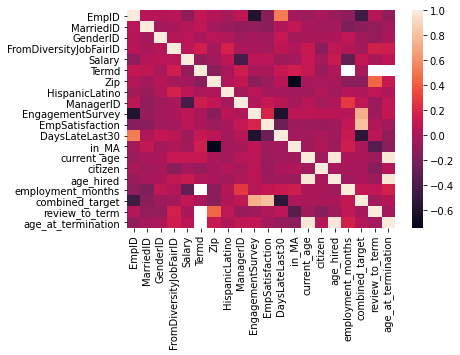

In [91]:
#Check for autocorrelation
sns.heatmap(df.corr())

Most of the strong correlations are the obvious ones. The list below is the features that are strongly correlated and the feature I will use for modeling is in parenthesis.

- zipcode, state and in MA (in MA)
- current age, DOB, age hired and age at termination (age hired)

I will also eliminate any features that would not be known prior to termination.

For the target, I will either use employee engagement or combined metric using engagement and satisfaction.

In [113]:
#Initial feature selection

cols_to_keep = ['MarriedID', 'GenderID','FromDiversityJobFairID', 'Salary', 
                'Position', 'HispanicLatino', 'RaceDesc', 'DateofHire',
                'Department','ManagerName', 'RecruitmentSource', 
                'PerformanceScore','SpecialProjectsCount',
                'LastPerformanceReview_Date', 'DaysLateLast30', 'Absences', 
                'in_MA','citizen', 'age_hired']

#check data types
df[cols_to_keep].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   MarriedID                   311 non-null    int64         
 1   GenderID                    311 non-null    int64         
 2   FromDiversityJobFairID      311 non-null    int64         
 3   Salary                      311 non-null    int64         
 4   Position                    311 non-null    object        
 5   HispanicLatino              311 non-null    int64         
 6   RaceDesc                    311 non-null    object        
 7   DateofHire                  311 non-null    datetime64[ns]
 8   Department                  311 non-null    object        
 9   ManagerName                 311 non-null    object        
 10  RecruitmentSource           311 non-null    object        
 11  PerformanceScore            311 non-null    object        